# Compilation of all feature data for the model

In [3]:
import datetime
import pandas as pd    
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point
import numpy as np
import shapely
from shapely import speedups
speedups.enabled
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
import get_geodata
from get_geodata import get_gdf
from get_geodata import get_census_bounds
from get_geodata import get_zipcode_bounds

import get_trafficdata
from get_trafficdata import get_alltraffic

## Zipcode boundary download

In [23]:
zips_sea = get_zipcode_bounds()

In [33]:
zips_sea.head()

,geometry,SHAPE_Area
ZIPCODE,,
98101,"POLYGON ((-122.32789 47.61571, -122.32790 47.6...",1.470012e+07
98102,"POLYGON ((-122.31234 47.64627, -122.31236 47.6...",4.322189e+07
98103,"POLYGON ((-122.32850 47.70136, -122.32850 47.7...",1.440083e+08
98104,"POLYGON ((-122.31699 47.60078, -122.31701 47.6...",2.108730e+07
98105,"MULTIPOLYGON (((-122.28680 47.65477, -122.2867...",9.703543e+07


## Census Boundary Download

In [34]:
census_bounds = get_census_bounds()

In [35]:
census_bounds.head()

,Tract,SHAPE_Area,geometry
0,25.0,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."
1,26.0,1.339838e+07,"POLYGON ((-122.30817 47.69031, -122.30947 47.6..."
2,56.0,3.212601e+07,"POLYGON ((-122.39300 47.63956, -122.39421 47.6..."
3,68.0,7.729233e+06,"POLYGON ((-122.35070 47.63994, -122.35130 47.6..."
4,60.0,1.413816e+07,"POLYGON ((-122.34279 47.64320, -122.34280 47.6..."


We also need to get the centroids of the census tract data for the population data set.

<ipython-input-36-4938a179621d>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_cent['geometry'] = census_cent['geometry'].centroid


<AxesSubplot:>

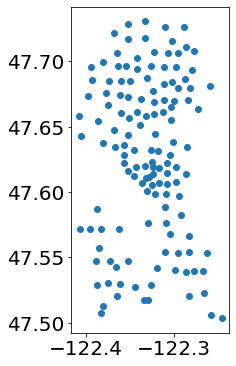

In [36]:
#Centroid points of census tracts
census_cent = census_bounds.copy()

census_cent['geometry'] = census_cent['geometry'].centroid
census_cent.plot(figsize=(15,6))

## Bike Rack data

In [24]:
# Loads bike rack data
racks_url = 'https://opendata.arcgis.com/datasets/f86c29ce743e47819e588c3d643ceb63_0.geojson'
r = gpd.read_file(racks_url)

In [38]:
# Creates a dataframe "racks" of bike rack locations and years installed
racks = r[['INSTALL_DATE', 'RACK_CAPACITY', 'geometry']]
racks = racks[racks.INSTALL_DATE.notnull()]
racks['Year'] = pd.DatetimeIndex(racks['INSTALL_DATE']).year
racks = racks.drop(columns='INSTALL_DATE')

In [39]:
# Filters dataframe to include only years 2007 - 2018
filter1 = racks['Year'] >= 2007
filter2 = racks['Year'] <= 2018
racks_filtered = racks[filter1 & filter2]

In [40]:
zips_racks = gpd.sjoin(zips_sea, racks_filtered, op='contains')
zips_racks.reset_index(inplace=True)
zips_racks = zips_racks[['ZIPCODE', 'Year', 'RACK_CAPACITY']]
zips_racks.drop_duplicates(subset=['ZIPCODE', 'Year'], inplace=True)
zips_racks.sort_values(by=['ZIPCODE', 'Year'], inplace=True)

In [41]:
zips_racks.head()

,ZIPCODE,Year,RACK_CAPACITY
31,98101,2007,2
0,98101,2008,2
2,98101,2009,2
43,98101,2010,2
47,98101,2011,2


## Bike Lanes

In [19]:
# Loads data: bike lanes and walkways
bike_lanes_url = 'https://gisdata.seattle.gov/server/rest/services/SDOT/SDOT_Bikes/MapServer/1/query?where=1%3D1&outFields=OBJECTID,STREET_NAME,LENGTH_MILES,SHAPE,DATE_COMPLETED,SHAPE_Length&outSR=4326&f=json'
lanes = gpd.read_file(bike_lanes_url)

In [63]:
# Creates dataframe
lane_columns = ['LENGTH_MILES', 'DATE_COMPLETED', 'geometry']
bike_lane = lanes[lane_columns]
bike_lane['DATE_COMPLETED'] = pd.to_datetime(bike_lane['DATE_COMPLETED'], unit='ms')
bike_lane['Year'] = pd.DatetimeIndex(bike_lane['DATE_COMPLETED']).year
bike_lane = bike_lane.drop(columns='DATE_COMPLETED')
bike_lane['Year'] = bike_lane['Year'].fillna(0)

/home/mcanin/miniconda3/envs/green_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [68]:
# Filters dataframe to include only years 2007 - 2018
filter1 = bike_lane['Year'] >= 2007
filter2 = bike_lane['Year'] <= 2018
bike_lane_filtered = bike_lane[filter1 & filter2]

# Spatially joins bike lanes dataframe with zip code boundaries dataframe
zips_lanes = gpd.sjoin(zips_sea, bike_lane_filtered, op='intersects')
zips_lanes['Year'] = zips_lanes['Year'].astype(int)
zips_lanes.reset_index(inplace=True)
zips_lanes.drop_duplicates(subset=['ZIPCODE', 'Year'], inplace=True)
zips_lanes = zips_lanes[['ZIPCODE', 'Year', 'LENGTH_MILES']]
zips_lanes.sort_values(by=['ZIPCODE', 'Year'], inplace=True)

In [65]:
# Zip codes and bike lanes before 2007
bike_lane_baseline = bike_lane[bike_lane['Year'] < 2007]
zips_lane_base = gpd.sjoin(zips_sea, bike_lane_baseline, op='intersects')
zips_lane_base.reset_index(inplace=True)
zips_lane_base.drop_duplicates(subset=['ZIPCODE', 'Year'], inplace=True)
zips_lane_base = zips_lane_base.groupby(by='ZIPCODE').sum()
zips_lane_base.reset_index(inplace=True)
zips_lane_base = zips_lane_base[['ZIPCODE', 'Year', 'LENGTH_MILES']]

In [66]:
zip_list = list(zips_lanes.ZIPCODE.unique())

In [69]:
zips_lanes.head()

,ZIPCODE,Year,LENGTH_MILES
4,98101,2008,0.057961
2,98101,2009,0.019839
0,98101,2012,0.046915
9,98101,2018,0.080686
15,98102,2008,0.054256


In [400]:
'''
for i in range(0,2):
    base_val = zips_lane[zips_lane_base.ZIPCODE == lst[i]].iloc[0,-1]
    print(base_val)
    
    #add = zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1] + zips_lane_base[zips_lane_base.ZIPCODE==zipcode].iloc[0,-1]
    zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1] = add
    print(zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1])
'''

'\nfor i in range(0,2):\n    base_val = zips_lane[zips_lane_base.ZIPCODE == lst[i]].iloc[0,-1]\n    print(base_val)\n    \n    #add = zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1] + zips_lane_base[zips_lane_base.ZIPCODE==zipcode].iloc[0,-1]\n    zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1] = add\n    print(zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1])\n'

In [401]:
# Creates a dataframe "zipracks" of zip codes, years, and area density of bike racks (*10^6)
'''
zipracks = zr.groupby(['Zipcode', 'Year']).size().reset_index()
zipracks.rename(columns={0: 'Num_racks'}, inplace=True)
zip_list = zipracks.Zipcode.unique()
for zipcode in zip_list:
    indices = zipracks[zipracks.Zipcode==zipcode].index
    zipracks.loc[indices, 'Num_racks'] = zipracks.loc[indices, 'Num_racks'].cumsum()
    area = ziptracts[ziptracts.Zipcode==zipcode]['Area (ft^2)?'].unique()
    zipracks.loc[indices, 'Num_racks'] = zipracks.loc[indices, 'Num_racks'] / area * 10**6
zipracks.rename(columns={'Num_racks': 'Density_racks'}, inplace=True)
'''

"\nzipracks = zr.groupby(['Zipcode', 'Year']).size().reset_index()\nzipracks.rename(columns={0: 'Num_racks'}, inplace=True)\nzip_list = zipracks.Zipcode.unique()\nfor zipcode in zip_list:\n    indices = zipracks[zipracks.Zipcode==zipcode].index\n    zipracks.loc[indices, 'Num_racks'] = zipracks.loc[indices, 'Num_racks'].cumsum()\n    area = ziptracts[ziptracts.Zipcode==zipcode]['Area (ft^2)?'].unique()\n    zipracks.loc[indices, 'Num_racks'] = zipracks.loc[indices, 'Num_racks'] / area * 10**6\nzipracks.rename(columns={'Num_racks': 'Density_racks'}, inplace=True)\n"

In [402]:
'''
zip_sum_list = []*len(zip_list)
for zipcode in zip_list:
    selection = zips_lane_base_diss.loc[zips_lane_base_diss['ZIPCODE'] == zipcode]
    zip_sum = selection['LENGTH_MILES'].sum()
    zip_sum_list.append(zip_sum)
zip_sum_list
'''

"\nzip_sum_list = []*len(zip_list)\nfor zipcode in zip_list:\n    selection = zips_lane_base_diss.loc[zips_lane_base_diss['ZIPCODE'] == zipcode]\n    zip_sum = selection['LENGTH_MILES'].sum()\n    zip_sum_list.append(zip_sum)\nzip_sum_list\n"

In [55]:
#base_df = pd.DataFrame(list(zip(zip_list, year_fill, zip_sum_list)), index = range(len(zip_list)), columns = ['ZIPCODE', 'Year', 'Miles_Bike_Lanes'] )

## Sidewalks

In [321]:
sidewalks_url = 'https://gisdata.seattle.gov/server/rest/services/SDOT/SDOT_Pedestrian/MapServer/2/query?where=1%3D1&outFields=ADDDTTM,SHAPE_Length&outSR=4326&f=json'
df_sidewalks = gpd.read_file(sidewalks_url)

In [459]:
df_sidewalks.head()

,ADDDTTM,SHAPE_Length,geometry
0,1190827054000,630.165238,"LINESTRING (-122.31212 47.69312, -122.30956 47..."
1,1190827054000,331.689269,"LINESTRING (-122.35537 47.66294, -122.35403 47..."
2,1190827054000,213.981813,"LINESTRING (-122.36591 47.53319, -122.36591 47..."
3,1190827054000,779.970572,"LINESTRING (-122.36417 47.55744, -122.36421 47..."
4,1190827054000,583.589982,"LINESTRING (-122.34954 47.64303, -122.34928 47..."


In [460]:
sidewalk_col = ['ADDDTTM','SHAPE_Length','geometry']
sidewalks = df_sidewalks.loc[:,sidewalk_col]

sw_times = []
for timestamp in sidewalks['ADDDTTM'].values:
    x = timestamp[:10]
    x_time = datetime.datetime.fromtimestamp(int(x)).isoformat()
    x_year = (int(x_time[0:4]))
    sw_times.append(x_year)

#sidewalks['ADDDTM'] = pd.to_datetime(sidewalks['ADDDTTM'], unit='ms')
#sidewalks['Year'] = pd.DatetimeIndex(sidewalks['ADDDTTM']).year


In [461]:
sidewalks['Year'] = pd.Series(sw_times)
sidewalks.drop(columns='ADDDTTM', inplace=True)

In [462]:
sidewalks.head()

,SHAPE_Length,geometry,Year
0,630.165238,"LINESTRING (-122.31212 47.69312, -122.30956 47...",2007
1,331.689269,"LINESTRING (-122.35537 47.66294, -122.35403 47...",2007
2,213.981813,"LINESTRING (-122.36591 47.53319, -122.36591 47...",2007
3,779.970572,"LINESTRING (-122.36417 47.55744, -122.36421 47...",2007
4,583.589982,"LINESTRING (-122.34954 47.64303, -122.34928 47...",2007


In [463]:
# Selects only data points with years after 2007 to match traffic data
sidewalks_half_filtered = sidewalks[sidewalks['Year'] >= 2007]
# Selects only data points with years before 2018 to match traffic data
sidewalks_filtered = sidewalks_half_filtered[sidewalks_half_filtered['Year'] <= 2018]

In [464]:
# Drops rows with missing geometries
sidewalks_filtered.drop(index=sidewalks_filtered[sidewalks_filtered['geometry'].is_empty].index, inplace=True)

In [465]:
sidewalk_mids = sidewalks_filtered.copy()
sidewalk_mids['MIDPOINT'] = sidewalks_filtered['geometry'].interpolate(0.5, normalized=True)

<ipython-input-465-d2ae4cd6ba4f>:2: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sidewalk_mids['MIDPOINT'] = sidewalks_filtered['geometry'].interpolate(0.5, normalized=True)


In [466]:
# Joins zip codes with sidewalks
zips_sidewalks = gpd.sjoin(zips_sea, sidewalk_mids, op='intersects')
zips_sidewalks.reset_index(inplace=True)

In [467]:
zips_sidewalks = zips_sidewalks[['ZIPCODE', 'Year', 'SHAPE_Length']]
zips_sidewalks = zips_sidewalks.groupby(by=['ZIPCODE', 'Year']).sum()
zips_sidewalks.rename(columns={'SHAPE_Length': 'Sidewalk_length'}, inplace=True)
zips_sidewalks.sort_values(['ZIPCODE', 'Year'], inplace=True)
zips_sidewalks.reset_index(inplace=True)

In [468]:
zips_sidewalks.head()

,ZIPCODE,Year,Sidewalk_length
0,98101,2007,3665.759660
1,98102,2007,5673.521031
2,98103,2007,23336.847896
3,98103,2015,98.211326
4,98104,2007,2934.090918


## Populations

The population data is sorted by census tract, so to avoid double counting populations we will do a spatial join by centroids instead of across the two polygons.

In [98]:
# Loads data
pop_url_2010 = 'https://gisrevprxy.seattle.gov/arcgis/rest/services/CENSUS_EXT/CENSUS_2010_BASICS/MapServer/15/query?where=1%3D1&outFields=SHAPE,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID&outSR=4326&f=json'
p = gpd.read_file(pop_url_2010)

In [109]:
# Creates dataframe of 2010 population by census tract
pop_2010 = p.copy()
pop_2010.NAME10 = pop_2010.NAME10.astype(float)
pop_2010['geometry'] = census_cent['geometry']

In [144]:
pop_2010.head()

,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID,geometry
0,53033002500,25.0,243.219083,2802.0,1,POINT (-122.30228 47.68390)
1,53033002600,26.0,307.584420,4660.0,2,POINT (-122.31193 47.68275)
2,53033005600,56.0,737.511727,6382.0,3,POINT (-122.40574 47.64278)
3,53033006800,68.0,177.438771,2834.0,4,POINT (-122.35646 47.63603)
4,53033006000,60.0,324.567432,5150.0,5,POINT (-122.35286 47.64393)


In [139]:
# Spatially joins population dataframe with zip code boundaries dataframe
pop_zips = gpd.sjoin(zips_sea, pop_2010, op='contains')
pop_zips.reset_index(inplace=True)
pop_zips = pop_zips[['ZIPCODE','geometry', 'Total_Population']]
pop_zips = pop_zips.groupby(by='ZIPCODE').sum()
pop_zips.reset_index(inplace=True)
total_pop = pop_zips['Total_Population'].sum()

# Adds a column for population fraction
pop_zips['Pop_fraction'] = pop_zips['Total_Population']/total_pop

In [145]:
def est_pop(year):
    """
    This function...
    """
    years = list(range(2007, 2019))
    populations = [585436, 591870, 598539, 608660, 622694, 635928, 653588, 670109, 687386, 709631, 728661, 742235]
    pop_by_year = dict(zip(years, populations))
    
    pops = pop_zips
    pop_frac = pop_zips['Pop_fraction'].values
    year_pop = pop_by_year.get(year)
    pop_zip_year = pop_zips.copy()
    pop_zip_year['Total_Population'] = pop_frac*year_pop
    
    return pop_zip_year

In [146]:
# Creates dataframe of population by zip code and year.
pop_zips_years = gpd.GeoDataFrame()
years = list(range(2007, 2019))

for year in years:
    pop_zip_year = est_pop(year)
    pop_zip_year['Year'] = year
    pop_zips_years = pop_zips_years.append(pop_zip_year)
pop_zips_years = pop_zips_years[['ZIPCODE', 'Year', 'Total_Population', 'Pop_fraction']]
pop_zips_years.sort_values(by=['ZIPCODE', 'Year'], inplace=True)

In [149]:
pop_zips_years.head()

,ZIPCODE,Year,Total_Population,Pop_fraction
0,98101,2007,9478.973121,0.016191
0,98101,2008,9583.147981,0.016191
0,98101,2009,9691.127797,0.016191
0,98101,2010,9855.000000,0.016191
0,98101,2011,10082.228781,0.016191


## Getting traffic data for 2017

In [367]:
from traffic_df import final_df

In [370]:
traffic = final_df()

/mnt/c/Users/Matthew Canin/Desktop/0 UW/0 ChemE MS/1 Q2 Winter/1 DS 545-546/Greening Seattle/Prediction/traffic_df.py:81: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  midpoints['MIDPOINT'] = gdf_test['geometry'].interpolate(0.5, normalized = True)
/mnt/c/Users/Matthew Canin/Desktop/0 UW/0 ChemE MS/1 Q2 Winter/1 DS 545-546/Greening Seattle/Prediction/traffic_df.py:81: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  midpoints['MIDPOINT'] = gdf_test['geometry'].interpolate(0.5, normalized = True)
/mnt/c/Users/Matthew Canin/Desktop/0 UW/0 ChemE MS/1 Q2 Winter/1 DS 545-546/Greening Seattle/Prediction/traffic_df.py:81: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrec

In [376]:
traffic.rename(columns={'YEAR':'Year'}, inplace=True)

In [620]:
traffic.head()

,ZIPCODE,Year,AAWDT
0,98101,2007,264800.0
0,98101,2008,254100.0
0,98101,2009,254100.0
0,98101,2010,257900.0
0,98101,2011,353100.0


# Merging all features into one dataset for model

In [148]:
a = pd.merge(traffic, pop_zips_years, how='left', on= ['Year', 'ZIPCODE'])

NameError: name 'traffic' is not defined

In [518]:
a.head()

,ZIPCODE,Year,AAWDT,Total_Population,Pop_fraction
0,98101,2007,264800.0,9478.973121,0.016191
1,98101,2008,254100.0,9583.147981,0.016191
2,98101,2009,254100.0,9691.127797,0.016191
3,98101,2010,257900.0,9855.000000,0.016191
4,98101,2011,353100.0,10082.228781,0.016191


In [519]:
b = pd.merge(a, zips_racks, how='left', on= ['Year', 'ZIPCODE'])

In [614]:
c = pd.merge(b, zips_lanes, how='left', on =['Year', 'ZIPCODE'])

In [572]:
#all_data = pd.merge(c, zips_sidewalks, how='left', on =['Year', 'ZIPCODE'])

In [615]:
all_data = c.copy()

In [616]:
all_data.head()

,ZIPCODE,Year,AAWDT,Total_Population,Pop_fraction,RACK_CAPACITY,Miles_Bike_Lanes
0,98101,2007,264800.0,9478.973121,0.016191,2.0,NaN
1,98101,2008,254100.0,9583.147981,0.016191,2.0,0.320152
2,98101,2009,254100.0,9691.127797,0.016191,2.0,0.263767
3,98101,2010,257900.0,9855.000000,0.016191,2.0,NaN
4,98101,2011,353100.0,10082.228781,0.016191,2.0,NaN


In [617]:
# Removes zip codes with lots of missing data
all_data.fillna(0, inplace=True)
removed_zips_index = [21, 23, 24, 25, 26, 27, 28]
for i in removed_zips_index:
    all_data.drop(all_data[all_data.ZIPCODE==zip_list[i]].index, inplace=True)

In [618]:
# Inserts cumulative bike rack capacities and bike lane lengths over time
zip_list = all_data.ZIPCODE.unique()
for zipcode in zip_list:
    indices = all_data[all_data.ZIPCODE==zipcode].index
    all_data.loc[indices, ['RACK_CAPACITY', 'Miles_Bike_Lanes']] = all_data.loc[indices, ['RACK_CAPACITY', 'Miles_Bike_Lanes']].cumsum()

In [619]:
i = 19
all_data[all_data.ZIPCODE==zip_list[i]]

,ZIPCODE,Year,AAWDT,Total_Population,Pop_fraction,RACK_CAPACITY,Miles_Bike_Lanes
228,98133,2007,224400.000000,24008.589354,0.04101,0.0,0.000000
229,98133,2008,215300.000000,24272.446144,0.04101,0.0,0.000000
230,98133,2009,200100.000000,24545.940228,0.04101,2.0,1.164354
231,98133,2010,214900.000000,24961.000000,0.04101,2.0,1.214407
232,98133,2011,219300.000000,25536.530960,0.04101,2.0,1.392986
233,98133,2012,217880.000000,26079.254112,0.04101,4.0,1.392986
234,98133,2013,214000.000000,26803.486459,0.04101,4.0,1.392986
235,98133,2014,216500.000000,27481.008690,0.04101,6.0,1.392986
236,98133,2015,659800.784906,28189.534298,0.04101,8.0,1.519320
237,98133,2016,659800.784906,29101.796390,0.04101,8.0,1.644569


In [530]:
zip_list

array([98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109,
       98112, 98115, 98116, 98117, 98118, 98119, 98121, 98122, 98125,
       98126, 98133, 98134, 98136, 98144, 98146, 98155, 98177, 98178,
       98195, 98199])

In [149]:
for year in years:
    all_data_year = all_data.loc[all_data['Year'] == year]
    print(year, ':', all_data_year.isnull().sum())

2007 : ZIPCODE              0
Year                 0
AAWDT                0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        9
Miles_Bike_Lanes    16
Sidewalk_length      1
dtype: int64
2008 : ZIPCODE              0
Year                 0
AAWDT                0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        6
Miles_Bike_Lanes     7
Sidewalk_length     28
dtype: int64
2009 : ZIPCODE              0
Year                 0
AAWDT                0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        5
Miles_Bike_Lanes     6
Sidewalk_length     28
dtype: int64
2010 : ZIPCODE              0
Year                 0
AAWDT                0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY       11
Miles_Bike_Lanes    12
Sidewalk_length     28
dtype: int64
2011 : ZIPCODE              0
Year                 0
AAWDT                0
Total_Population     1
Pop_fraction         1
RACK_CAPACITY       15
Miles_Bike_Lanes    16
Sidewalk_length 

Years with at least one instance of all 4 features: 2008, 2014 - 2018

For 2008:
* lanes has data for 98109 and 98126
* walks has 98136

For 2014: 
* lanes has data for 98105, 98112, 98126, 98144
* walks has 98117

For 2015: 
* lanes has data for 98103, 98105, 98106, 98108, 98109, 98112, 98116, 98117, 98119, 98126, 98144, 98146, 98145, 98199
* walks has 98106 and 98121
* __98106 is a match__

For 2016: 
* lanes has data for 98103, 98105, 98112, 98115
* walks has 98119, 98121, and and 98199

For 2017: 
* lanes has data for 98104, 98105, 98106, 98107, 98108, 98112, 98115, 98116, 98118, 98119, 98121, 98122, 98125, 98126, 98136, 98144
* walks has 98112, 98118, 98126, and 98144
* __98112, 98118, 98126, and 98144 is a match__

For 2018: 
* lanes has data for 98101, 98118, 98122, and 98126
* walks has 98104, 98105, 98107, 98116, and 98126
* __98126 is a match__

In [255]:
zips_lanes_2018 = zips_lanes_clean.loc[zips_lanes_clean['Year'] == 2018]

In [256]:
zips_lanes_2018

,Year,ZIPCODE,Lane_Length
69,2018,98101,348.181761
70,2018,98118,269.759130
71,2018,98122,134.256722
72,2018,98126,103.611745


In [257]:
zips_walks_2018 = zips_walkways_clean.loc[zips_walkways_clean['Year'] == 2018]

In [258]:
zips_walks_2018

,Year,ZIPCODE,Walkway_Length
11,2018,98104,612.361474
12,2018,98105,909.234692
13,2018,98107,195.281209
14,2018,98116,1319.979585
15,2018,98126,1422.466556


In [261]:
zips_racks_2017 = zips_racks_clean.loc[zips_racks_clean['Year'] == 2017]
zips_racks_2017

,Year,ZIPCODE,RACK_CAPACITY
205,2017,98101,6
206,2017,98102,22
207,2017,98103,20
208,2017,98104,102
209,2017,98106,24
210,2017,98107,28
211,2017,98108,6
212,2017,98109,16
213,2017,98112,2
214,2017,98115,2


In [259]:
zips_racks_2010 = zips_racks.loc[zips_racks['Year'] == 2010]

In [124]:
zips_racks_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY
65,2010,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",148.04,2.940025e+07,2082,4
66,2010,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",296.08,1.728875e+08,9258,8
67,2010,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",315.00,1.008058e+09,14057,32
68,2010,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,30,14
69,2010,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",205.00,4.851772e+08,9872,22


In [125]:
zips_lanes_2010 = zips_lanes.loc[zips_lanes['Year'] == 2010]
zips_lanes_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
7,2010,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18952,6,157.179735


In [126]:
zips_walkways_2010 = zips_walkways.loc[zips_walkways['Year'] == 2010]
zips_walkways_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng


In [127]:
pops_zips_years_2010 = pop_zips_years.loc[pop_zips_years['Year'] == 2010]
pops_zips_years_2010.head()

,Year,ZIPCODE,Total_Population,Pop_fraction,geometry
0,2010,98101,9855.0,0.016191,"POLYGON ((-122.34598 47.60892, -122.34490 47.6..."
1,2010,98102,12451.0,0.020456,"POLYGON ((-122.33574 47.64203, -122.33108 47.6..."
2,2010,98103,43659.0,0.071730,"POLYGON ((-122.35808 47.69966, -122.35741 47.6..."
3,2010,98104,9674.0,0.015894,"POLYGON ((-122.34105 47.59627, -122.34031 47.5..."
4,2010,98105,44553.0,0.073199,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286..."


In [140]:
len(pops_zips_years_2010)

28

In [130]:
zips_racks_2010_pd = pd.DataFrame(zips_racks_2010)

In [131]:
pops_zips_years_2010_pd = pd.DataFrame(pops_zips_years_2010)

In [150]:
test = pd.merge(pops_zips_years_2010_pd, zips_racks_2010,  how ='left', on='ZIPCODE')

In [151]:
len(test)

28

In [152]:
test2 = pd.merge(test, zips_lanes_2010, how = 'left', on = 'ZIPCODE')

In [153]:
len(test2)

28

In [156]:
test2.head(10)

,Year_x,ZIPCODE,Total_Population,Pop_fraction,geometry_x,Year_y,geometry_y,NAME10_x,SHAPE_Area_left_x,index_right_x,RACK_CAPACITY,Year,geometry,NAME10_y,SHAPE_Area_left_y,index_right_y,SEGMENT_TY,SHAPE_Leng
0,2010,98101,9855.0,0.016191,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",2010.0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",148.04,2.940025e+07,2082.0,4.0,NaN,None,NaN,NaN,NaN,NaN,NaN
1,2010,98102,12451.0,0.020456,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",2010.0,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",296.08,1.728875e+08,9258.0,8.0,NaN,None,NaN,NaN,NaN,NaN,NaN
2,2010,98103,43659.0,0.071730,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",2010.0,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",315.00,1.008058e+09,14057.0,32.0,NaN,None,NaN,NaN,NaN,NaN,NaN
3,2010,98104,9674.0,0.015894,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",2010.0,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,30.0,14.0,NaN,None,NaN,NaN,NaN,NaN,NaN
4,2010,98105,44553.0,0.073199,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",2010.0,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",205.00,4.851772e+08,9872.0,22.0,NaN,None,NaN,NaN,NaN,NaN,NaN
5,2010,98106,23568.0,0.038721,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",2010.0,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",114.02,1.482014e+08,1142.0,2.0,NaN,None,NaN,NaN,NaN,NaN,NaN
6,2010,98107,22263.0,0.036577,"MULTIPOLYGON (((-122.40896 47.67540, -122.4072...",2010.0,"MULTIPOLYGON (((-122.40896 47.67540, -122.4072...",96.00,1.309021e+08,3303.0,16.0,NaN,None,NaN,NaN,NaN,NaN,NaN
7,2010,98108,22590.0,0.037114,"POLYGON ((-122.33799 47.53397, -122.33787 47.5...",2010.0,"POLYGON ((-122.33799 47.53397, -122.33787 47.5...",465.00,1.075290e+09,10624.0,10.0,NaN,None,NaN,NaN,NaN,NaN,NaN
8,2010,98109,31473.0,0.051709,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",NaN,None,NaN,NaN,NaN,NaN,2010.0,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18952.0,6.0,157.179735
9,2010,98112,24148.0,0.039674,"MULTIPOLYGON (((-122.31863 47.63041, -122.3186...",2010.0,"MULTIPOLYGON (((-122.31863 47.63049, -122.3186...",130.00,1.763729e+08,713.0,4.0,NaN,None,NaN,NaN,NaN,NaN,NaN
